# Previsão de Fraude de Cartão de Crédito 

O presente projeto tem como objetivo analisar um conjunto de dados de transações de cartões de crédito e desenvolver um modelo preditivo capaz de identificar se uma transação é fraudulenta ou não. Para isso, serão aplicadas técnicas de exploração de dados, tratamento do dataset, seleção de variáveis, além de métodos de aprendizado de máquina voltados para detecção de fraudes.

- DICIONÁRIO DA BASE
---

1. **Time:** Tempo em segundos entre da trasação em relação a primeira transação do dataset.
2. **V1 até V28:** São dados que foram padronizados e coletados as informações que tinham mais relevância, ou seja, foi aplicado um processo de PCA. Isso foi feito por motivos de confidencialidade dos dados. 3. Os dados estão na seguinte padronização: média valendo 0 e desvio padrão valendo 1.
4. **Amount:** Valor da transação realizada.
5. **Class:** 0 para não fraude e 1 para fraude. 

- IMPORTS
---

In [41]:
# Manipulação
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Divisão de dados/Nétricas/Validação Cruzada
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Otimização de modelo
from sklearn.model_selection import GridSearchCV

# Utils
from utils import train_predict_evaluate

# Configurações
pd.set_option('display.max_columns', None)

- LENDO DATASET E TRATANDO OS DADOS
---

In [23]:
# Analisando o conjunto dos dados
df = pd.read_csv(r'..\data\creditcard.csv')
display(df.head())
df.info()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [24]:
# Verificando duplicatas e valores nulos
print('Valores duplicados:', df.duplicated().sum())

print('\nValores nulos:', df.isna().sum().sum())

Valores duplicados: 1081

Valores nulos: 0


In [25]:
# Removendo duplicatas
df.drop_duplicates(inplace=True)

- ANÁLISE EXPLORATÓRIA
---

In [26]:
# Analisando estatísticas
df.describe().drop(columns=['Class']).T.round(2)

,count,mean,std,min,25%,50%,75%,max
Time,283726.0,94811.08,47481.05,0.00,54204.75,84692.50,139298.00,172792.00
V1,283726.0,0.01,1.95,-56.41,-0.92,0.02,1.32,2.45
V2,283726.0,-0.00,1.65,-72.72,-0.60,0.06,0.80,22.06
V3,283726.0,0.00,1.51,-48.33,-0.89,0.18,1.03,9.38
V4,283726.0,-0.00,1.41,-5.68,-0.85,-0.02,0.74,16.88
V5,283726.0,0.00,1.38,-113.74,-0.69,-0.05,0.61,34.80
V6,283726.0,-0.00,1.33,-26.16,-0.77,-0.28,0.40,73.30
V7,283726.0,0.00,1.23,-43.56,-0.55,0.04,0.57,120.59
V8,283726.0,-0.00,1.18,-73.22,-0.21,0.02,0.33,20.01
V9,283726.0,-0.00,1.10,-13.43,-0.64,-0.05,0.60,15.59


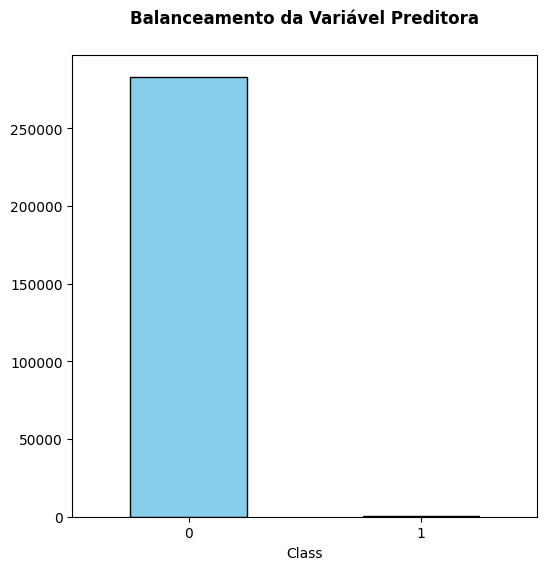

Porcentagem de fraudes: 0.00167


In [27]:
# Balanceamento da target
df.Class.value_counts().plot(kind='bar', figsize=(6,6), color=['skyblue', 'red'], edgecolor='black')
plt.title('Balanceamento da Variável Preditora', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

print('Porcentagem de fraudes:', round(df.Class.value_counts()[1] / len(df), 5))

Existe um forte desbalanceamento na coluna Class (a variável preditora). Existem muito mais dados que não foram fraude do que dados que foram fraude (menos de 1% no dataset).  

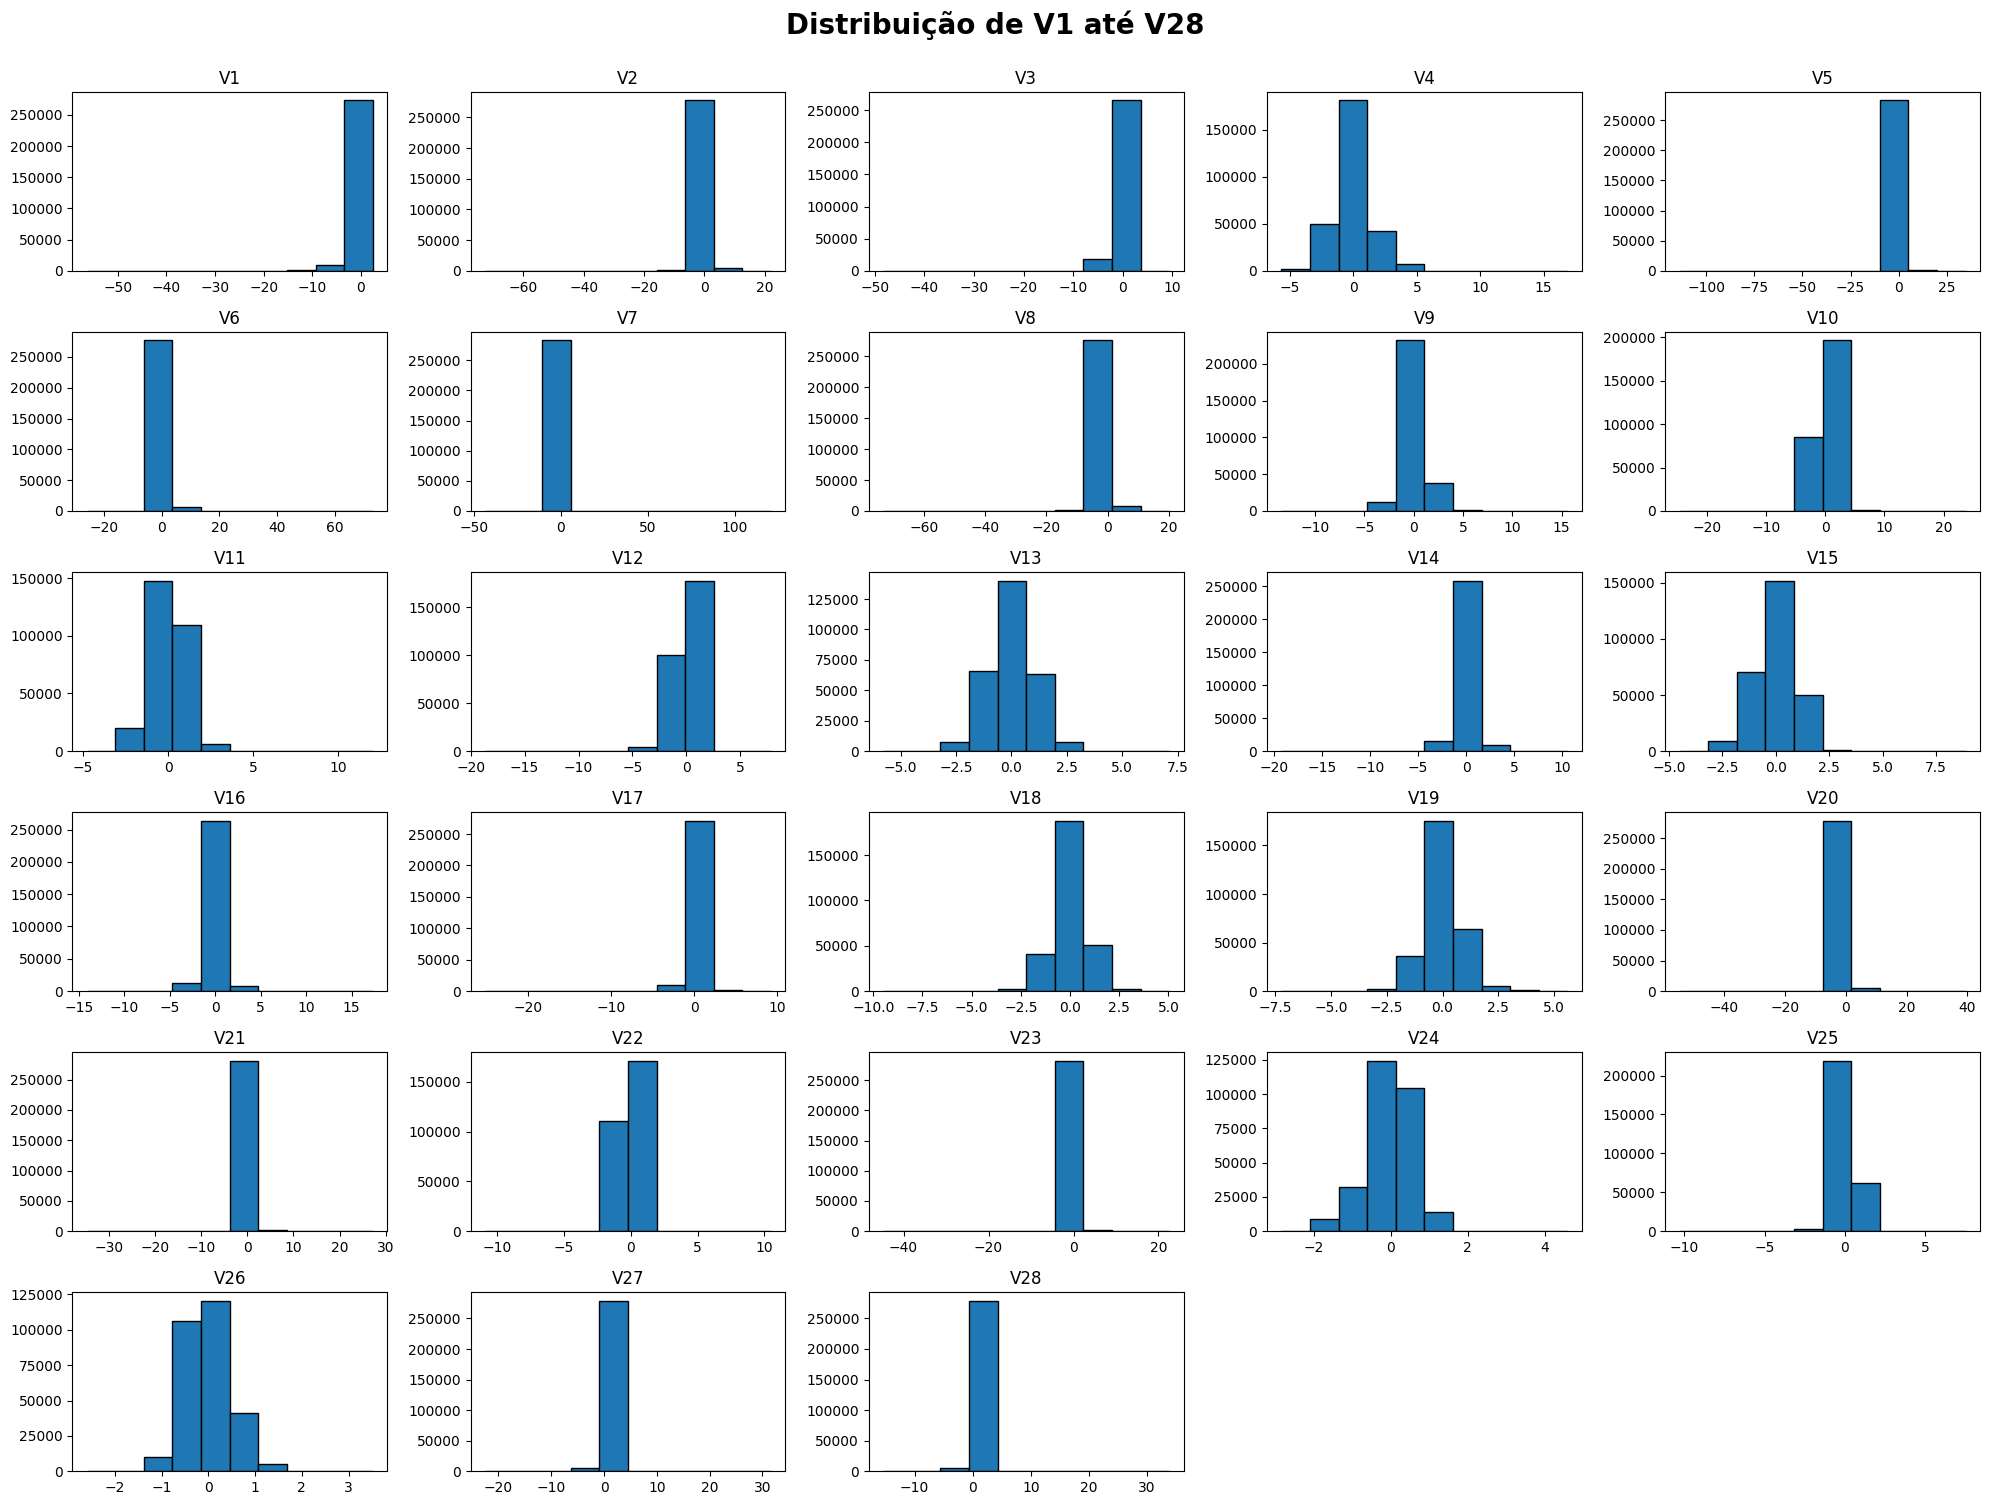

In [28]:
# Distribuições das colunas V1 até V28
df.drop(columns=['Class', 'Time', 'Amount']).hist(figsize=(20,15), edgecolor='black', grid=False)
plt.suptitle('Distribuição de V1 até V28', fontsize=20, y=1, fontweight='bold')
plt.tight_layout()
plt.show()

Todas as variáveis tem uma distribuição com mediana próximo a zero, o que faz sentido, pois as variáveis já vieram padronizadas com média de 0 e desvio padrão 1.

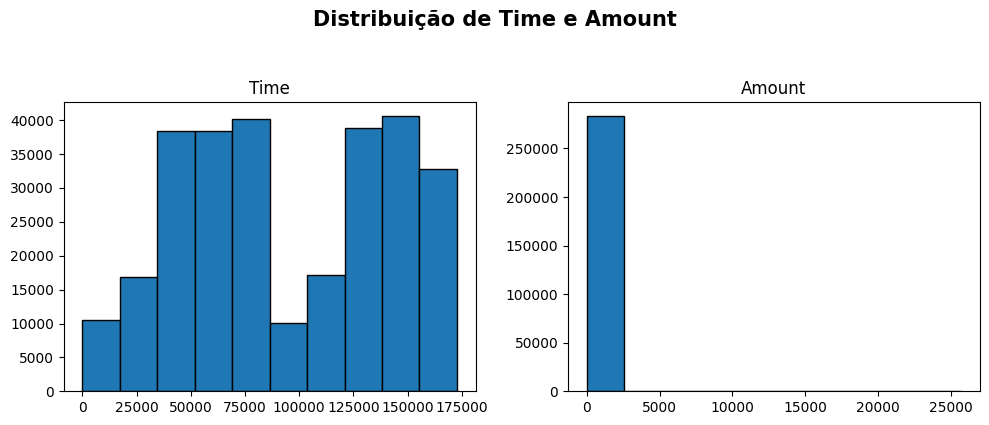

In [29]:
# Distribuições das colunas Time e Amount
df[['Time', 'Amount']].hist(figsize=(10,4), edgecolor='black', grid=False)
plt.suptitle('Distribuição de Time e Amount', fontsize=15, y=1.05, fontweight='bold')
plt.tight_layout()
plt.show()

Os dados da coluna Time apresentam uma distribuição homogênea, ou seja, bem distribuida. Já na coluna Amount, observa-se uma forte concentração dos valores próximos de zero, sugerindo uma distribuição assimétrica e a possível presença de valores extremos.

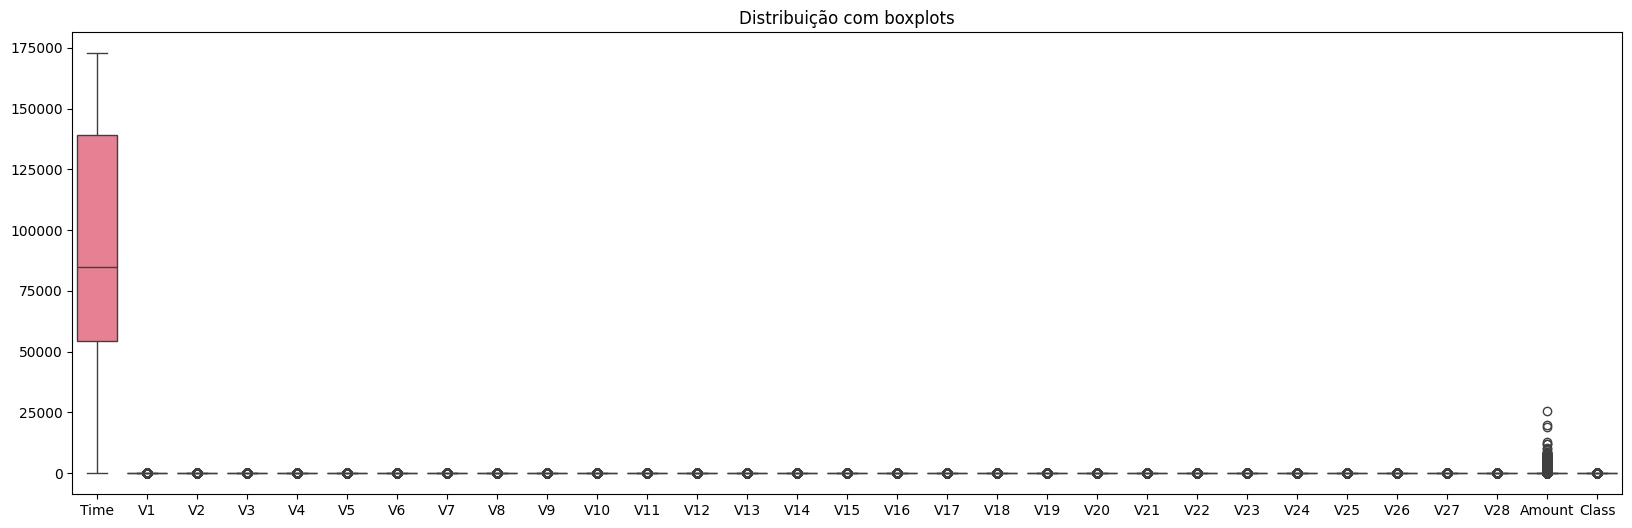

In [30]:
plt.figure(figsize=(20,6))  
sns.boxplot(data=df)
plt.title('Distribuição com boxplots')
plt.show()

O boxplot apresenta a distribuição dos valores para várias colunas do conjunto de dados, destacando principalmente as colunas Time e Amount. A variável Time exibe uma distribuição ampla, com valores que variam desde zero até cerca de 175.000. A maior parte dos dados está concentrada dentro de um intervalo significativo, sem a presença evidente de outliers. Já a variável Amount mostra uma concentração muito grande de valores próximos de zero, com diversos pontos isolados que indicam a existência de valores extremos ou outliers bastante elevados. Essa assimetria na distribuição sugere que a coluna Amount possui uma cauda longa com poucos valores muito altos. As outras variáveis, como V1 a V28 e Class, também apresentam muitos pontos dispersos, indicando a presença frequente de valores atípicos. De modo geral, Time tem uma distribuição mais uniforme e sem grandes outliers, enquanto Amount e as demais variáveis possuem distribuições assimétricas com outliers, o que pode exigir cuidados e transformações para análises futuras.

- DIVISÃO DOS DADOS
---

In [31]:
# Didindo base em treino e validação
train, val = train_test_split(df, test_size=0.3, random_state=42)

In [32]:
# Analisando a quantidade de train
display(train.head())
train.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
9303,13475.0,1.062798,-0.007554,1.169893,1.694109,-0.559090,0.527767,-0.608457,0.254902,1.958445,-0.442814,1.889295,-1.352906,0.801253,1.351972,-2.100985,-0.688038,1.023403,-0.124233,-0.242592,-0.269189,-0.175983,0.050427,-0.040761,0.185224,0.516446,-0.325208,0.039374,0.007193,9.00,0
76408,56552.0,0.847556,-0.338382,-0.191249,0.644180,-0.183540,-0.714065,0.632148,-0.252654,-0.251573,-0.201071,0.059191,0.506093,0.286965,0.507920,1.011023,-0.250848,0.021733,-1.319204,-0.316838,0.294179,-0.230173,-1.113621,-0.005678,0.078580,0.146345,0.145774,-0.084227,0.041947,209.85,0
241084,150877.0,0.128523,-0.516833,-0.142250,-0.928846,0.527405,-0.707555,0.005645,-0.057433,-1.121318,0.510696,0.184722,0.279765,0.201481,0.316081,-0.414356,-1.676994,-0.459069,2.089722,-0.388451,-0.373181,0.107889,0.729755,-0.064491,-0.465817,-0.107939,-0.024985,0.029513,-0.020921,28.28,0
51506,44987.0,-0.681253,-3.310937,-0.269365,1.180375,-0.761417,2.582536,0.234441,0.505835,1.011396,-0.922163,-0.667479,0.631733,0.068872,-0.223372,0.885422,-1.011110,0.990799,-1.982577,-1.294401,1.601252,0.395436,-0.489844,-0.710257,-1.720611,-0.280947,0.460254,-0.090716,0.156289,906.32,0
30861,36110.0,1.268610,0.069977,0.331383,0.725081,-0.315020,-0.434386,-0.032536,-0.105304,0.499264,-0.192168,-1.108620,0.308201,0.044376,-0.098223,-0.174709,-0.137830,-0.148217,-0.551539,0.406253,-0.106359,-0.265292,-0.576113,-0.048183,-0.082980,0.520402,0.300388,-0.022789,0.007630,5.97,0


(198608, 31)

In [33]:
# Analisando a quantidade de train
display(val.head())
val.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
104697,69195.0,1.054379,-0.764756,0.160168,0.665587,1.113466,4.771656,-1.536609,1.306483,1.565054,-0.349941,-1.238496,0.608002,-0.249115,-0.933969,-1.407873,-0.191383,-0.180853,0.226980,0.537470,0.050995,-0.097138,-0.029759,-0.171596,1.047201,0.698595,-0.217939,0.101970,0.040152,56.42,0
134356,80769.0,-4.805134,4.351191,-0.916135,-0.900752,-0.870777,-0.782946,0.328104,0.582501,2.749336,4.728060,0.455162,0.649740,0.930379,-1.663325,1.334738,-0.283321,0.152340,-0.950771,-0.935567,2.160193,-0.854486,-0.758266,0.147005,-0.021274,0.552660,0.008318,0.431835,-0.436239,9.82,0
42637,41182.0,-1.549833,-0.261143,1.556289,-2.037817,-0.366315,-1.334314,0.165406,-0.025782,-1.472751,-0.172838,-0.594842,0.063059,1.054185,-0.171535,0.192041,-0.867483,-0.348274,0.743352,-1.454672,-0.347365,-0.405656,-0.951005,-0.147752,0.424100,0.081845,1.103559,-0.502271,-0.248822,46.08,0
882,666.0,0.216344,0.663182,1.303520,0.169219,-0.404266,-0.517288,-0.036938,-0.838221,-0.528675,-0.174777,1.648466,1.114947,0.202150,0.479424,0.226420,0.456003,-0.558258,-0.101939,0.000758,-0.184929,0.552788,-0.961206,-0.014642,0.525962,0.750877,0.141543,0.045107,0.127321,3.58,0
263275,160870.0,-0.273365,0.825649,0.555674,0.384915,1.343842,1.984159,0.321808,0.510275,-0.891463,-0.115561,0.952916,-0.221254,-0.867646,0.974855,2.441035,-1.711023,0.902400,0.022272,2.097232,0.172188,0.346482,1.162889,-0.557535,-0.896146,0.503553,0.555129,0.129099,0.047571,2.84,0


(85118, 31)

In [34]:
# Divisão de features e target
# Train
x = train.drop(columns=['Class'])
y = train['Class']

# Val
x_val = val.drop(columns=['Class'])
y_val = val['Class']

In [35]:
# Verificando Train
print('X TRAIN:')
display(x.head())
display(x.shape)

print('Y TRAIN:')
y.head()

X TRAIN:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
9303,13475.0,1.062798,-0.007554,1.169893,1.694109,-0.559090,0.527767,-0.608457,0.254902,1.958445,-0.442814,1.889295,-1.352906,0.801253,1.351972,-2.100985,-0.688038,1.023403,-0.124233,-0.242592,-0.269189,-0.175983,0.050427,-0.040761,0.185224,0.516446,-0.325208,0.039374,0.007193,9.00
76408,56552.0,0.847556,-0.338382,-0.191249,0.644180,-0.183540,-0.714065,0.632148,-0.252654,-0.251573,-0.201071,0.059191,0.506093,0.286965,0.507920,1.011023,-0.250848,0.021733,-1.319204,-0.316838,0.294179,-0.230173,-1.113621,-0.005678,0.078580,0.146345,0.145774,-0.084227,0.041947,209.85
241084,150877.0,0.128523,-0.516833,-0.142250,-0.928846,0.527405,-0.707555,0.005645,-0.057433,-1.121318,0.510696,0.184722,0.279765,0.201481,0.316081,-0.414356,-1.676994,-0.459069,2.089722,-0.388451,-0.373181,0.107889,0.729755,-0.064491,-0.465817,-0.107939,-0.024985,0.029513,-0.020921,28.28
51506,44987.0,-0.681253,-3.310937,-0.269365,1.180375,-0.761417,2.582536,0.234441,0.505835,1.011396,-0.922163,-0.667479,0.631733,0.068872,-0.223372,0.885422,-1.011110,0.990799,-1.982577,-1.294401,1.601252,0.395436,-0.489844,-0.710257,-1.720611,-0.280947,0.460254,-0.090716,0.156289,906.32
30861,36110.0,1.268610,0.069977,0.331383,0.725081,-0.315020,-0.434386,-0.032536,-0.105304,0.499264,-0.192168,-1.108620,0.308201,0.044376,-0.098223,-0.174709,-0.137830,-0.148217,-0.551539,0.406253,-0.106359,-0.265292,-0.576113,-0.048183,-0.082980,0.520402,0.300388,-0.022789,0.007630,5.97


(198608, 30)

Y TRAIN:


9303      0
76408     0
241084    0
51506     0
30861     0
Name: Class, dtype: int64

In [36]:
# Verificando Val
print('X VALIDATION:')
display(x_val.head())
display(x_val.shape)

print('Y:')
y_val.head()

X VALIDATION:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
104697,69195.0,1.054379,-0.764756,0.160168,0.665587,1.113466,4.771656,-1.536609,1.306483,1.565054,-0.349941,-1.238496,0.608002,-0.249115,-0.933969,-1.407873,-0.191383,-0.180853,0.226980,0.537470,0.050995,-0.097138,-0.029759,-0.171596,1.047201,0.698595,-0.217939,0.101970,0.040152,56.42
134356,80769.0,-4.805134,4.351191,-0.916135,-0.900752,-0.870777,-0.782946,0.328104,0.582501,2.749336,4.728060,0.455162,0.649740,0.930379,-1.663325,1.334738,-0.283321,0.152340,-0.950771,-0.935567,2.160193,-0.854486,-0.758266,0.147005,-0.021274,0.552660,0.008318,0.431835,-0.436239,9.82
42637,41182.0,-1.549833,-0.261143,1.556289,-2.037817,-0.366315,-1.334314,0.165406,-0.025782,-1.472751,-0.172838,-0.594842,0.063059,1.054185,-0.171535,0.192041,-0.867483,-0.348274,0.743352,-1.454672,-0.347365,-0.405656,-0.951005,-0.147752,0.424100,0.081845,1.103559,-0.502271,-0.248822,46.08
882,666.0,0.216344,0.663182,1.303520,0.169219,-0.404266,-0.517288,-0.036938,-0.838221,-0.528675,-0.174777,1.648466,1.114947,0.202150,0.479424,0.226420,0.456003,-0.558258,-0.101939,0.000758,-0.184929,0.552788,-0.961206,-0.014642,0.525962,0.750877,0.141543,0.045107,0.127321,3.58
263275,160870.0,-0.273365,0.825649,0.555674,0.384915,1.343842,1.984159,0.321808,0.510275,-0.891463,-0.115561,0.952916,-0.221254,-0.867646,0.974855,2.441035,-1.711023,0.902400,0.022272,2.097232,0.172188,0.346482,1.162889,-0.557535,-0.896146,0.503553,0.555129,0.129099,0.047571,2.84


(85118, 30)

Y:


104697    0
134356    0
42637     0
882       0
263275    0
Name: Class, dtype: int64

Nesta etapa, realizei a divisão do conjunto de dados em treino e validação. Em seguida, separei as variáveis independentes (features) da variável dependente (target)

- VALIDAÇÃO CRUZADA E TREINAMENTO DE MODELOS
---

Para iniciar a validação cruzada e o treinamento, primeiro é necessário a definição dos modelos que serão utilizados. Para este caso, utilizarei os seguintes modelos: 
- **XGBoost**
- **LightGBM**
- **CatBoost**

**Por que sses modelos?**

Como esses modelos são baseados em árvores de decisão, não se importam com outliers, ou seja, os outliers não irão prejudicar a previsão. Além disso, modelos Boosting conseguem se sair bem em casos em que é preciso prever dados desbalanceados, pois são modelos em que utiliza o método Gradient Boosting, que são conjuntos de modelos fracos, que se torna um modelos forte, pois a cada modelo ele irá reduzir mais os erros.

In [37]:
# Definindo modelos
xgb = XGBClassifier()
lgbm = LGBMClassifier(verbose=0)
cat = CatBoostClassifier(verbose=0)

In [38]:
# Aplicando validação cruzada
xgb_cross_val = cross_val_score(xgb, x, y, cv=5, scoring='recall').mean()
lgbm_cross_val = cross_val_score(lgbm, x, y, cv=5, scoring='recall').mean()
cat_cross_val = cross_val_score(cat, x, y, cv=5, scoring='recall').mean()

print(f'XBG VALIDATION SCORE: {xgb_cross_val:.2f}')
print(f'LGBM VALIDATION SCORE: {lgbm_cross_val:.2f}')
print(f'CAT VALIDATION SCORE: {cat_cross_val:.2f}')

XBG VALIDATION SCORE: 0.78
LGBM VALIDATION SCORE: 0.63
CAT VALIDATION SCORE: 0.80


Todo os modelos performaram bem, porém o catboost se destacou. Por isso, irei utilizar ele para fazer o treino e teste, e após isso irei verificar suas métricas. Logo depois de ter o modelo treinado e avaliado corretamente, seguirei para tentar ajustar alguns parâmetros para melhorar seu desempenho ainda mais.

Reports:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39649
           1       0.94      0.85      0.89        73

    accuracy                           1.00     39722
   macro avg       0.97      0.92      0.95     39722
weighted avg       1.00      1.00      1.00     39722



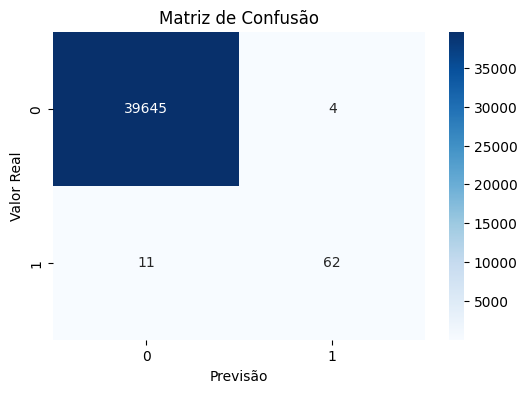

In [39]:
# Treinando e testando modelo
model_train = train_predict_evaluate(x=x, y=y, model=cat, train_step=True)

Reports:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17000
           1       0.95      0.79      0.86        24

    accuracy                           1.00     17024
   macro avg       0.97      0.90      0.93     17024
weighted avg       1.00      1.00      1.00     17024



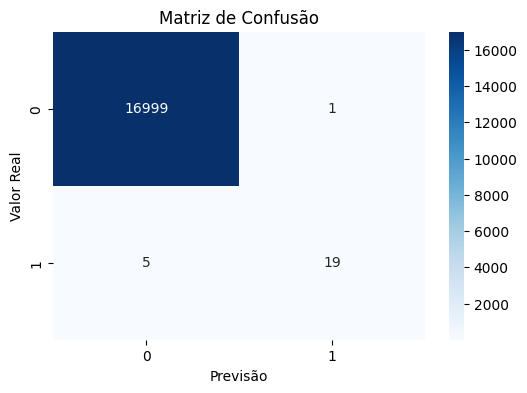

In [40]:
# Testando com a base de avaliação
final_model = train_predict_evaluate(x=x_val, y=y_val, model=model_train, train_step=False) 

Após o treinamento e o teste com a base de treino, o modelo teve uma performance muito boa! Logo após isso, fiz o teste com a base de validação, para verificar se o modelo não estava apenas decorando os dados (overfitting). Depois de usar o modelo treinado na base de validação, o modelo conseguiu alcançar um recall de 79%, conseguindo acertar boa parte das transações fraudulentas. Além dessa performance, posso tentar melhora-lo ainda mais, otimizando alguns parâmetros.

- OTIMIZANDO HIPERPARÂMETROS
---